### This notebook checks OM anisotropy in `jampy` against analytic value in the spherical case.

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import warnings

try:
    import paperfig as pf
    pf.set_fontscale(2.)
except:
    pass

In [2]:
from lenstronomy.GalKin.analytic_kinematics import AnalyticKinematics
from lenstronomy.GalKin.numeric_kinematics import NumericKinematics
from lenstronomy.Analysis.kinematics_api import KinematicsAPI
from astropy.cosmology import FlatLambdaCDM

In [3]:
r_eff = 1.85
theta_e = 1.63
gamma = 1.95
z_d = 0.295
z_s = 0.657
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_d = cosmo.angular_diameter_distance(z_d).value


def get_v_rms_numeric(rs, theta_e, gamma, r_eff, a_ani=1,
                      z_d=z_d, z_s=z_s, analytic=False, do_mge=False,
                      hernquist_mass=None, anisotropy_type='OM',
                      hernquist_light=False
                      ):
    """
    Compute v_rms for power-law mass and Hernquist light using Galkin's numerical
    approach.
    :param hernquist_mass: if mass in M_sun provided, uses Hernquist mass profile. For debugging purpose.
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value

    kwargs_cosmo = {'d_d': D_d, 'd_s': D_s, 'd_ds': D_ds}
    
    kwargs_aperture = {'aperture_type': 'IFU_shells',
                       'r_bins': rs,
                       }
    
    kwargs_seeing = {'psf_type': 'GAUSSIAN',
                     'fwhm': 1e-3,
                     }
    
    kwargs_galkin_numerics = {#'sampling_number': 1000,
                              'interpol_grid_num': 1000,
                              'log_integration': True,
                              'max_integrate': 100,
                              'min_integrate': 0.001}
    
    if hernquist_mass is None:
        if hernquist_light:
            kwargs_model = {
                        'lens_model_list': ['PEMD'],
                        'lens_light_model_list': ['HERNQUIST'],
                    }
        else:
            kwargs_model = {
                    'lens_model_list': ['PEMD'],
                    'lens_light_model_list': ['SERSIC', 'SERSIC'],
                }
    else:
        kwargs_model = {
                'lens_model_list': ['HERNQUIST'],
                'lens_light_model_list': ['HERNQUIST'],
            }

    print(kwargs_model)
    kinematics_api = KinematicsAPI(z_lens=z_d, z_source=z_s,
                                   kwargs_model=kwargs_model,
                                   kwargs_aperture=kwargs_aperture,
                                   kwargs_seeing=kwargs_seeing,
                                   anisotropy_model=anisotropy_type,
                                   cosmo=cosmo,
                                   multi_observations=False,
                                   kwargs_numerics_galkin=kwargs_galkin_numerics,
                                   analytic_kinematics=analytic,
                                   Hernquist_approx=False,
                                   MGE_light=True,
                                   MGE_mass=do_mge, #self._cgd,
                                   kwargs_mge_light=None,
                                   kwargs_mge_mass=None,
                                   sampling_number=1000,
                                   num_kin_sampling=2000,
                                   num_psf_sampling=500,
                                   )
    
    if hernquist_mass is None:
        if hernquist_light:
            kwargs_mass = [{
                'theta_E': theta_e, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 
                'e1': 0, 'e2': 0
            }]

            kwargs_light = [{
                'Rs': 0.63, 'amp': 1, 'center_x': 0, 'center_y': 0
            }]
        else:
            kwargs_mass = [{
                'theta_E': theta_e, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 
                'e1': 0, 'e2': 0
            }]

            kwargs_light = [
                {'R_sersic': r_eff/1.85*2.49*np.sqrt(0.878), 'n_sersic': 0.93, 'amp': 0.091, 'center_x': 0, 'center_y': 0},
                {'R_sersic': r_eff/1.85*0.362*np.sqrt(0.849), 'n_sersic': 1.59, 'amp': 0.89, 'center_x': 0, 'center_y': 0},
            ]
    else:
        Rs = 0.551 * r_eff
        Rs_Mpc = Rs / 206265 * D_d
        
        lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)
        
        sigma_0 = (hernquist_mass / (2 * np.pi * Rs_Mpc**2)) / lens_cosmo.sigma_crit 
        
        kwargs_mass = [{
            'Rs': 0.551 * r_eff, 'sigma0': sigma_0, 'center_x': 0, 'center_y': 0
        }]


        kwargs_light = [{
            'Rs': r_eff * 0.551, 'amp': 1., 'center_x': 0, 'center_y': 0
        }]

    if anisotropy_type == 'OM':
        kwargs_anisotropy = {
            'r_ani': a_ani * r_eff
        }
    elif anisotropy_type == 'const':
        kwargs_anisotropy = {
            'beta': a_ani
        }
    
    vel_dis = kinematics_api.velocity_dispersion_map(
                    kwargs_mass,
                    kwargs_light,
                    kwargs_anisotropy,
                    # r_eff=(1+np.sqrt(2))*r_eff, theta_E=theta_E,
                    # gamma=gamma,
                    kappa_ext=0,
                    direct_convolve=False,
#                     supersampling_factor=supersampling_factor,
#                     voronoi_bins=voronoi_bins,
#                     get_IR_map=True
                )
    
    return vel_dis

In [4]:
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Util.param_util import ellipticity2phi_q
import lenstronomy.Util.multi_gauss_expansion as mge
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

In [5]:
from mgefit.mge_fit_1d import mge_fit_1d
from gaussian_decomposition import *


low_dex = -2.5
hi_dex = 2
n_gauss = 20


def get_light_cgd(r_eff, mge_in_2d=True, plot=False, 
                  get_light_profile=False, hernquist=False):
    """
    :return: surf_lum in 1/pc^2 unit and sigma_lum in arcsec unit
    """
    R_sersic_1 = r_eff/1.85*2.49*np.sqrt(0.878)
    amp_1 = 0.091
    n_sersic_1 = 0.93
    R_sersic_2 = r_eff/1.85*0.362*np.sqrt(0.849)
    amp_2 = 0.89
    n_sersic_2 = 1.59
    
    def func(R):
        return amp_1 * sersic_func(R/R_sersic_1, n_sersic=n_sersic_1) + amp_2 * sersic_func(R/R_sersic_2, n_sersic=n_sersic_2)
    
    delta_sigma = (hi_dex - low_dex)/n_gauss
    surf_lum, sigma_lum = decompose(func, 10**(low_dex+delta_sigma/2.), 10**(hi_dex-delta_sigma/2.),
                                    N_sigma=n_gauss
                                   )    

    return surf_lum, sigma_lum
    

    
def get_light_mge_2d(r_eff, mge_in_2d=True, plot=False, 
                     get_light_profile=False, hernquist=False):
    """
    """
    sigma_lum = np.array([ 0.24344635,  0.36067945,  0.60628114,  1.13855552,  1.86364175,
         2.6761396 ,  3.55367977,  4.43848341,  5.33263851,  6.2222584 ,
         7.08440441,  8.12158143,  9.23341296, 10.29834757, 19.07959706]) * r_eff/1.85
    
    surf_lum = np.array([4.73320859e-01, 4.72402840e-01, 5.58995798e-01, 1.02666580e+00,
        2.02419303e+00, 1.77472748e+00, 6.56147174e-01, 1.03750980e-01,
        6.98808495e-03, 1.86209035e-04, 2.16341896e-06, 2.11474312e-09,
        9.61877415e-14, 2.46144638e-15, 1.71561703e-25]) / np.sqrt(2 * np.pi * sigma_lum**2)**2
    
    return surf_lum, sigma_lum


    
def get_light_mge_1d(r_eff, mge_in_2d=True, plot=False, 
                             get_light_profile=False, hernquist=False):
    """
    :return: surf_lum in 1/pc^2 unit and sigma_lum in arcsec unit
    """
    if not hernquist:
        light_model = LightModel(['SERSIC', 'SERSIC'])
        kwargs_light = [
                {'R_sersic': r_eff/1.85*2.49*np.sqrt(0.878), 'n_sersic': 0.93, 'amp': 0.091, 
                 'center_x': 0, 'center_y': 0},
                {'R_sersic': r_eff/1.85*0.362*np.sqrt(0.849), 'n_sersic': 1.59, 'amp': 0.89, 
                 'center_x': 0, 'center_y': 0},
            ]
    else:
        light_model = LightModel(['HERNQUIST'])
        kwargs_light = [
            {'Rs': 0.63, 'amp': 1, 'center_x': 0., 'center_y': 0.}
        ]
        
    n = 300
    rs = np.logspace(low_dex, hi_dex, n) * 0.551*r_eff
    
    if mge_in_2d:
        light_at_r = light_model.surface_brightness(rs, rs*0, kwargs_light)
    else:
        light_at_r = light_model.light_3d(rs, kwargs_light)
    
#     if plot:
#         plt.loglog(rs, light_at_r)
#         plt.show()
    
    if get_light_profile:
        return rs, light_at_r
    
    light_mge = mge_fit_1d(rs, light_at_r, ngauss=n_gauss, quiet=True, inner_slope=-1)

    sigma_lum = light_mge.sol[1] #/ (np.sqrt(2 * np.pi) * sigma_lum)
    
    if mge_in_2d:
        surf_lum = light_mge.sol[0] / (np.sqrt(2 * np.pi) * sigma_lum)
    else:
        surf_lum = light_mge.sol[0]
    
    if plot:
        light_mge.plot()
    
    return surf_lum, sigma_lum


def get_mass_mge(theta_e, gamma, z_d=0.5, z_s=2., plot=False, hernquist_mass=None):
    """
    :return: surf_pot in M_pc/pc^2 unit and sigma_pot in arcsec unit
    """
    if hernquist_mass is None:
        lens_model = LensModel(['PEMD'])

        rs = np.logspace(low_dex, hi_dex, 300) * theta_e

        kwargs_lens = [{'theta_E': theta_e, 'gamma': gamma, 
                        'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}]

        mass_at_r = lens_model.kappa(rs, rs*0, kwargs_lens)

        mass_mge = mge_fit_1d(rs, mass_at_r, ngauss=n_gauss, quiet=True)
        mass_amps, mass_sigmas = mass_mge.sol[0], mass_mge.sol[1]

        lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)
        
        sigma_pot = mass_sigmas
        surf_pot = lens_cosmo.kappa2proj_mass(mass_amps) / 1e12 / (np.sqrt(2 * np.pi) * (sigma_pot)) # / 206265 * D_d * 1e6))/ 2*np.pi / sigmas**2
    else:
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
        D_d = cosmo.angular_diameter_distance(z_d).value

        a_arcsec = 0.551 * theta_e
        a_Mpc = a_arcsec / 206265 * D_d
        a_pc = a_Mpc * 1e6
        
        n = 300  # Number of values to sample the H90 profile for the fit
        r_pc = np.logspace(low_dex, hi_dex, n)* a_pc   # logarithmically spaced radii in pc
        rho = hernquist_mass * a_pc / (2*np.pi * r_pc * (r_pc + a_pc)**3) 

        mass_mge = mge_fit_1d(r_pc, rho, ngauss=n_gauss, quiet=True)
        # plt.pause(1)

        surf_pot = mass_mge.sol[0]    # Surface density in Msun/pc**2
        sigma_pot = mass_mge.sol[1] / a_pc * a_arcsec
        
#         approx = 0
        
#         for amp, sig in zip(mass_mge.sol[0], mass_mge.sol[1]):
#             approx += amp/(np.sqrt(2 * np.pi) * sig)**1 * np.exp(-(r/a_pc*a)**2 / 2 / sig**2)
            
#         plt.loglog(r/a_pc*a, rho)
#         plt.loglog(r/a_pc*a, approx)
#         plt.xlim(1e-3, 1e2)
#         plt.ylim(1e-8, 1e4)
#         plt.show()
        
    if plot:
        mass_mge.plot()

    return surf_pot, sigma_pot

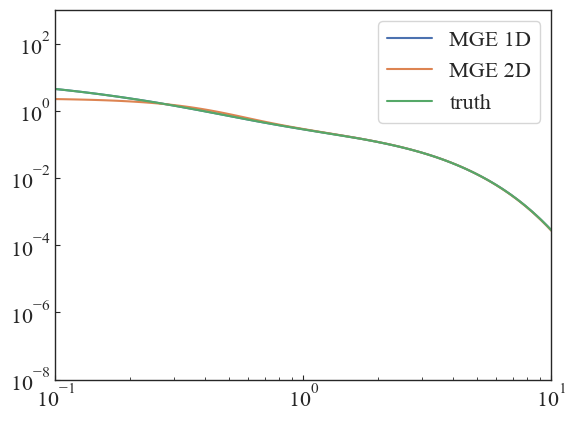

In [6]:
rs = np.logspace(-1, 1, 100)

surf_lum, sigma_lum = get_light_mge_1d(r_eff=r_eff)
plt.loglog(rs, sum_gauss_components(rs, surf_lum, sigma_lum), label='MGE 1D')

surf_lum, sigma_lum = get_light_mge_2d(r_eff=r_eff)
plt.loglog(rs, sum_gauss_components(rs, surf_lum, sigma_lum), label='MGE 2D')


# surf_lum, sigma_lum = get_light_mge_cappellari(r_eff=1)
# plt.loglog(rs, sum_gauss_components(rs, surf_lum, sigma_lum), label='MGE 1D')

plt.loglog(get_light_mge_1d(r_eff=r_eff, get_light_profile=True)[0], 
           get_light_mge_1d(r_eff=r_eff, get_light_profile=True)[1],
           label='truth'
          )


plt.ylim(1e-8, 1e3)
plt.xlim(rs[0], rs[-1])
plt.legend()


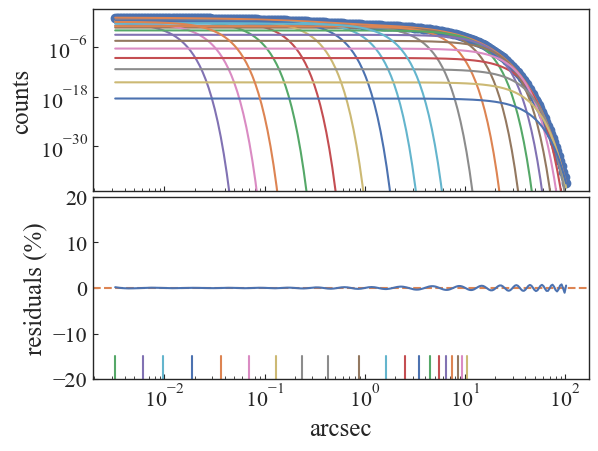

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


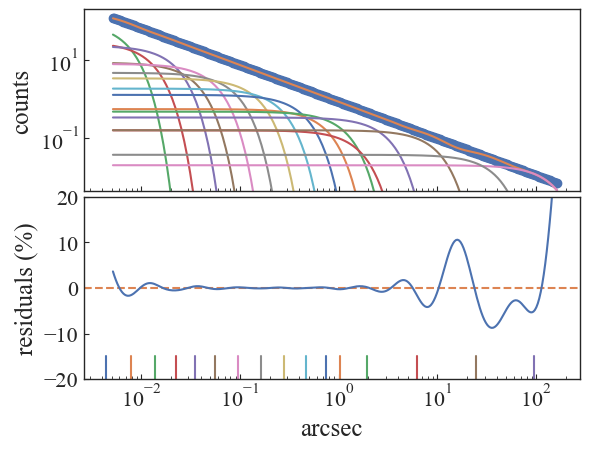

In [7]:
get_light_mge_1d(r_eff=r_eff, plot=True);
plt.show()
get_mass_mge(theta_e=theta_e, gamma=gamma, plot=True); #, hernquist_mass=1e11);

## check MGE decomposition by comparing circular velocity vs analytical

Check v_circular for fidelity of `surf_pot` and `sigma_pot`

In [8]:
get_light_mge = get_light_mge_1d

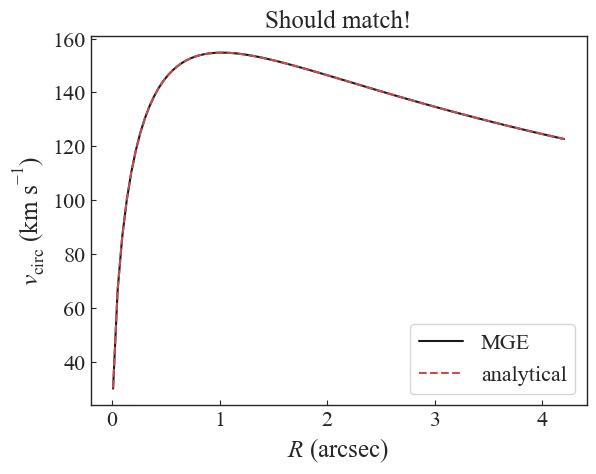

In [9]:
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_sph_rms import jam_sph_rms
from jampy.mge_vcirc import mge_vcirc


Rs = np.linspace(0.01, 4.2, 100)

M_hernquist = 1e11 # M_sun
surf_pot, sigma_pot = get_mass_mge(r_eff, gamma, 
                                   hernquist_mass=M_hernquist, z_s=z_s, z_d=z_d)


v_circ_mge = mge_vcirc(surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                  inc_deg=90, mbh=0, dist=D_d, rad=Rs)
plt.plot(Rs, v_circ_mge, 'k', label='MGE')

# Compare with analytic result
a_arcsec = 0.551 * r_eff
a_Mpc = a_arcsec / 206265 * D_d
a_pc = a_Mpc * 1e6
G = 0.004301

rs_pc = Rs  * a_pc / a_arcsec
v_circ_analytical = np.sqrt(G * M_hernquist * rs_pc) / (rs_pc + a_pc) # H90 equation (16)


plt.plot(Rs, v_circ_analytical, 'r--', label='analytical')
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm circ}$ (km s$^{-1}$)');
plt.legend()
plt.title('Should match!')
plt.show()

## Check Galkin numeric vs jampy with isotropic orbits and Hernquist mass+light profile

{'lens_model_list': ['HERNQUIST'], 'lens_light_model_list': ['HERNQUIST']}
{'lens_model_list': ['HERNQUIST'], 'lens_light_model_list': ['HERNQUIST']}
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.27
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.858e+11
jam_sph_rms elapsed time sec: 0.02
No PSF convolution: sigmapsf == 0; pixsize == 0;


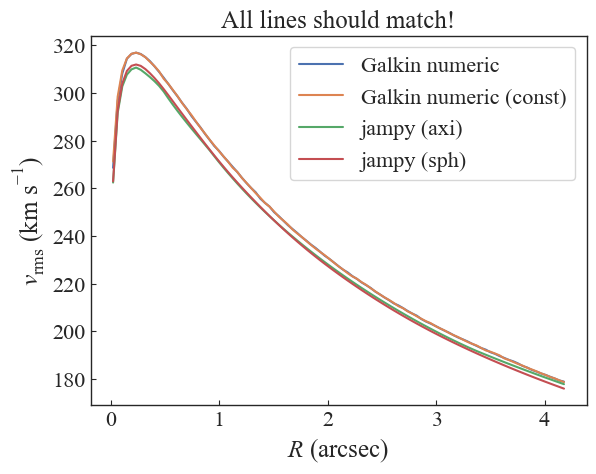

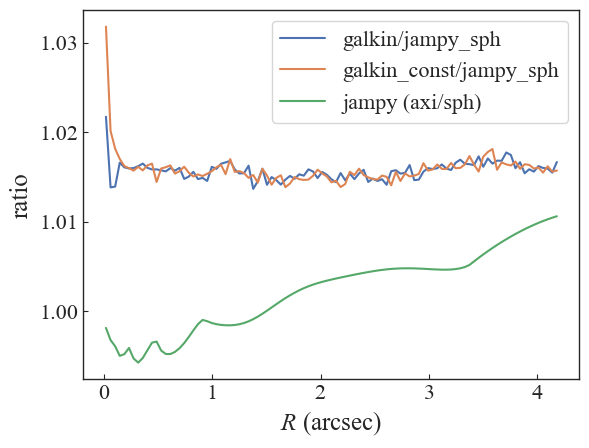

In [10]:
M_hernquist = 1e12 # M_sun

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e10
v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=M_hernquist)
v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=0, #isotropic 
                                  z_d=z_d, z_s=z_s, anisotropy_type='const',
                                  hernquist_mass=M_hernquist)



surf_pot, sigma_pot = get_mass_mge(r_eff, gamma, z_d=z_d, z_s=z_s,
                                   hernquist_mass=M_hernquist)
beta = np.ones_like(sigma_pot) * 0.

v_rms_axi = jam_axi_proj(surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         surf_pot, sigma_pot, np.ones_like(sigma_pot),
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
                         beta=beta, 
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_pot, sigma_pot, 
                        surf_pot, sigma_pot,
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        #beta=beta, 
                        scale=a_ani*r_eff,
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
plt.plot(Rs, v_rms_numeric_const, label='Galkin numeric (const)')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('All lines should match!')
plt.show()

plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin_const/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()


## Check Galkin analytic vs Galkin numeric vs jampy,  power-law+Sersic, with *isotropic orbits*

{'lens_model_list': ['PEMD'], 'lens_light_model_list': ['SERSIC', 'SERSIC']}
{'lens_model_list': ['PEMD'], 'lens_light_model_list': ['SERSIC', 'SERSIC']}
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.49
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.568e+13
jam_sph_rms elapsed time sec: 0.02
No PSF convolution: sigmapsf == 0; pixsize == 0;


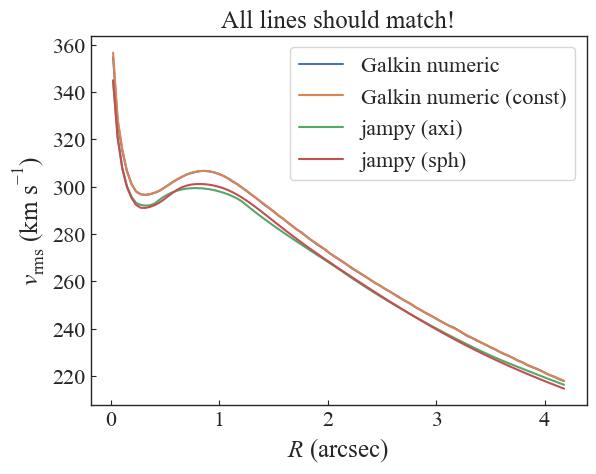

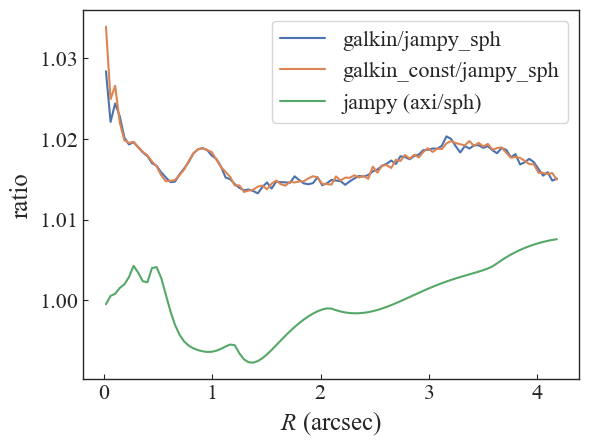

In [12]:
#v_rms_analytic = get_v_rms_analyitc(Rs, theta_e, gamma, r_eff, a_ani=1e3)

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e10
# v_rms_analytic = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
#                                    z_d=z_d, z_s=z_s,
#                                    hernquist_mass=None, analytic=True)
v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None)
v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=0, # isotropic
                                  z_d=z_d, z_s=z_s, anisotropy_type='const',
                                  hernquist_mass=None)
# v_rms_numeric_hern = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
#                                   z_d=z_d, z_s=z_s,
#                                   hernquist_mass=None, hernquist_light=True)



surf_pot, sigma_pot = get_mass_mge(theta_e, gamma, z_d=z_d, z_s=z_s)
surf_lum, sigma_lum = get_light_mge(r_eff, mge_in_2d=True)

beta = np.ones_like(sigma_lum) * 0. # isotropic

v_rms_axi = jam_axi_proj(surf_lum, sigma_lum, np.ones_like(sigma_lum),
                         surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
#                          sigmapsf=0.7/2.355,
                         beta=beta, 
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_lum, sigma_lum,
                        surf_pot, sigma_pot, 
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        beta=beta, 
#                         sigmapsf=0.7/2.355,
#                         normpsf=1.
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
# plt.plot(Rs, v_rms_analytic, label='Galkin analytic')
plt.plot(Rs, v_rms_numeric_const, label='Galkin numeric (const)')
# plt.plot(Rs, v_rms_numeric_hern, label='Galkin numeric (Hernquist)')

# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('All lines should match!')
plt.show()

plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin_const/jampy_sph')
# plt.plot(Rs, v_rms_numeric_hern/v_rms_sph, label='galkin_hern/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()


## Check Galkin analytic vs Galkin numeric vs jampy with power-law+Sersic light, and *radial orbits*

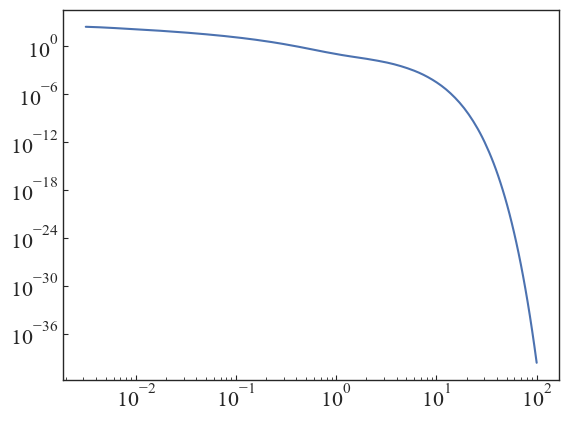

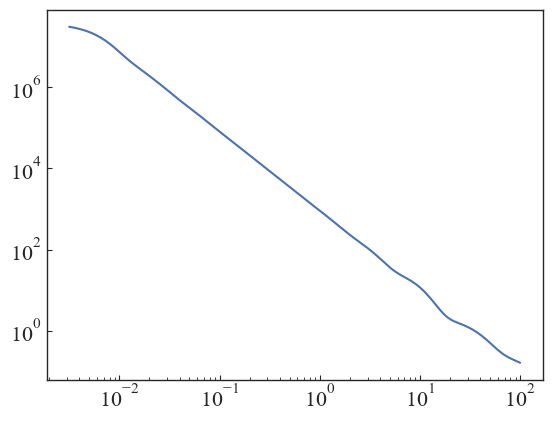

In [13]:
def plot_mge(sigs, amps):
    rs = np.logspace(-2.5, 2, 200)
    f = 0
    for s, a in zip(sigs, amps):
        f += a / np.sqrt(2 * np.pi * s**2) * np.exp(-rs**2/2/s**2)
    plt.loglog(rs, f)
    plt.show()
    
plot_mge(sigma_lum, surf_lum)
plot_mge(sigma_pot, surf_pot)

{'lens_model_list': ['PEMD'], 'lens_light_model_list': ['SERSIC', 'SERSIC']}
{'lens_model_list': ['PEMD'], 'lens_light_model_list': ['SERSIC', 'SERSIC']}
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 0.86
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=1.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 8.568e+13
jam_sph_rms elapsed time sec: 0.02
No PSF convolution: sigmapsf == 0; pixsize == 0;


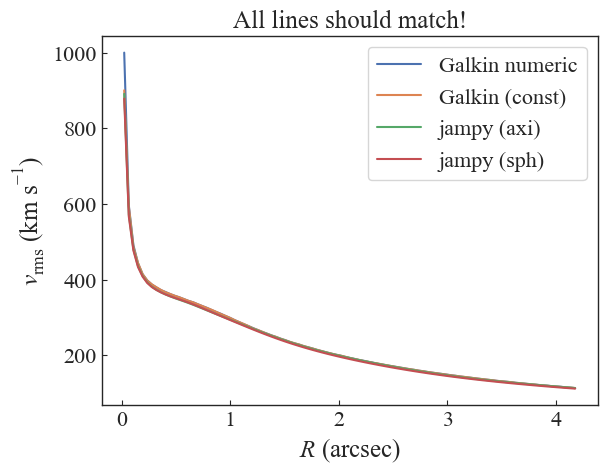

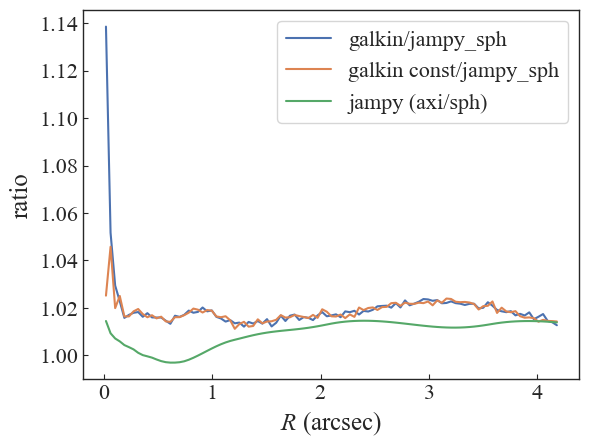

In [14]:
#v_rms_analytic = get_v_rms_analyitc(Rs, theta_e, gamma, r_eff, a_ani=1e3)

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e-10
# v_rms_analytic = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # radial
#                                   hernquist_mass=None, analytic=True)
v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # radial
                                  hernquist_mass=None, z_d=z_d, z_s=z_s)
v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=1, # radial
                                  hernquist_mass=None, z_d=z_d, z_s=z_s, anisotropy_type='const')



surf_pot, sigma_pot = get_mass_mge(theta_e, gamma, z_d=z_d, z_s=z_s)
surf_lum, sigma_lum = get_light_mge(r_eff, mge_in_2d=True)

beta = np.ones_like(sigma_lum) #(sigma_lum)**2 / ((a_ani * r_eff)**2 + sigma_lum**2) #np.ones_like(sigma_lum) * 0.

v_rms_axi = jam_axi_proj(surf_lum, sigma_lum, np.ones_like(sigma_lum),
                         surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
                         beta=beta, 
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_lum, sigma_lum,
                        surf_pot, sigma_pot, 
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        scale=a_ani*r_eff,
                        #beta=beta, 
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
plt.plot(Rs, v_rms_numeric_const, label='Galkin (const)')

# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('All lines should match!')
plt.show()


plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin const/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()


## check anisotropy profile